<table><tr>
<td> <img src="https://www.buteisland.com/wp-content/uploads/2017/11/tesco.png" alt="Drawing" style="width: 320px;"/> </td>
<td> <img src="https://blog.s4rb.com/hubfs/Blog%20Images/sainsburys-history.png" alt="Drawing" style="width: 280px;"/> </td>
</tr></table>

<h1 align=center><font size = 5>Capstone Project:</font></h1>
<h1 align=center><font size = 5>Explaining Customer Ratings of Tesco and Sainsbury's</font></h1>
<h1 align=center><font size = 4>By Zixiong Long</font></h1>

## Introduction
The key focus of this research is to uncover the exogenous factors that drive users’ ratings of a grocery store. To narrow down the problem, London is chosen as the city, and Tesco and Sainsbury’s are chosen as the grocery store companies of this analysis. It is constructed as a classification problem and the user ratings are the labels to be predicted. The final fine-tuned machine learning model will provide the best explanatory inputs that contribute to the ratings.

## 1. Import Libraries <a id="0"></a>

In [182]:
import pandas as pd
from pandas import json_normalize
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

import seaborn as sns
from matplotlib import pyplot as plt

from geopy.geocoders import Nominatim
import requests  
import folium
import re

## 2. Data Collecting and Wrangling <a id="1"></a>
Datasets used in this analysis are from three sources: Foursquare location data, Wikipedia and The London Datastore. The data extracted from these sources will become the inputs of the machine learning model to classify the ratings of grocery stores.

### 2.1 London Location Data<a id="2"></a>
The “List of areas of London” (https://en.wikipedia.org/wiki/List_of_areas_of_London) is used. It provides the areas and boroughs of London and the corresponding post codes, which will be used for the locations of the grocery stores in the model.

In [9]:
# load london locations file
london_data = pd.read_csv('London_locations.csv')
london_data.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,20,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",20,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,20,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,20,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",20,TQ478728


Let's cleansing the data to form a more handy DataFrame, and add coordinates to each borough

In [10]:
# drop rows where post town is not London
london_data = london_data[
              london_data['Post town'] == 'LONDON'
              ].reset_index(drop=True)

# rename the columns as the format is weird
london_data.columns = ['Location', 'London borough', 'Post town',
                       'Postcode district', 'Dial code', 'OS grid ref']

# drop columns of Post town, Dial code and OS grid ref
london_data.drop(['Post town', 'Dial code', 'OS grid ref'],
                 axis=1, inplace=True)

# remove brackets in column "Location" and column "London borough"
london_data['Location'] = london_data['Location'].str.split('\xa0').str[0]
london_data['London borough'] = london_data['London borough']\
                                .str.split('[').str[0]

# add coordinates to DataFrame
london_data['Latitude'] = None  # initialize two columns to None
london_data['Longitude'] = None

geolocator = Nominatim(user_agent="london_explorer")  # initialize locator

for i in range(london_data.shape[0]):
    address = london_data['Location'][i] + ', London'
    location = geolocator.geocode(address)
    if location is not None:
        london_data['Latitude'][i] = location.latitude
        london_data['Longitude'][i] = location.longitude
    print(i)

# drop row with None value in coordinates
london_data.dropna(subset=['Latitude'], axis=0, inplace=True)

# reset index
london_data.reset_index(drop=True, inplace=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
london_data.head()

,Location,London borough,Postcode district,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",SE2,51.4876,0.11405
1,Acton,"Ealing, Hammersmith and Fulham","W3, W4",51.5081,-0.273261
2,Aldgate,City,EC3,51.5142,-0.0757186
3,Aldwych,Westminster,WC2,51.5131,-0.117593
4,Anerley,Bromley,SE20,51.4076,-0.0619394


Now the DataFrame is cleaned with latitude and longitude added, and we will use these informatin to find grocery stores

### 2.2 Grocery Stores Data<a id="3"></a>
Foursquare API is the main source of data in this report. It is a popular location data vendor that provides venues locations, user ratings and tips, etc. It is utilised to find the coordinates of London’s Tesco stores, explore the neighbourhood of these stores and obtain the ratings of these stores.

In [12]:
# function to get stores raw data through Foursquare venue search
def get_stores(location_data, query, radius=1000, limit=100):

    CLIENT_ID = ''  # account ID
    CLIENT_SECRET = ''  # account password
    VERSION = '20200725'
    LIMIT = limit
    search_query = query
    n = location_data.shape[0]
    df = pd.DataFrame()

    for i in range(n):

        # get coordinates
        latitude = location_data['Latitude'][i]
        longitude = location_data['Longitude'][i]

        # Foursqure query
        url = 'https://api.foursquare.com/v2/venues/search?'\
              'client_id={}&client_secret={}&ll={},{}'\
              '&v={}&query={}&radius={}&limit={}'\
              .format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,
                      VERSION, search_query, radius, LIMIT
                      )

        try:
            venues = requests.get(url).json()['response']['venues']
        except KeyError:
            venues = []

        # tranform venues into a dataframe
        if len(venues) != 0:
            stores = json_normalize(venues)[
                ['id', 'name', 'categories', 'location.lat', 'location.lng']
            ]
            stores['location'] = location_data['Location'][i]
            stores['borough'] = location_data['London borough'][i]
            df = df.append(stores, ignore_index=True)

        print(i)

    df.rename(columns={'location.lat': 'latitude',
                       'location.lng': 'longitude'},
              inplace=True)

    return df

In [ ]:
# get stores raw data
tesco = get_stores(london_data, 'Tesco', radius=1000, limit=1000)
sainsbury = get_stores(london_data, 'Sainsbury', radius=1000, limit=1000)

In [14]:
tesco.head()

,id,name,categories,latitude,longitude,location,borough
0,4bdaced33904a593ec64479e,Tesco Express,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",51.508483,-0.281283,Acton,"Ealing, Hammersmith and Fulham"
1,4f575dd7e4b05abedfc29890,Tesco Express,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",51.514446,-0.076851,Aldgate,City
2,4b1abe09f964a520c4f023e3,Tesco Metro,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",51.517222,-0.080311,Aldgate,City
3,5332d2c2498e49c84573186a,Tesco Express,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",51.507199,-0.073972,Aldgate,City
4,4fdfa939e4b0c441c2653cbe,Tesco Metro,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",51.516805,-0.066368,Aldgate,City


In [15]:
sainsbury.head()

,id,name,categories,latitude,longitude,location,borough
0,55bb5956498e05559fb4e8c3,Sainsbury's,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",51.492826,0.120524,Abbey Wood,"Bexley, Greenwich"
1,4fae6beb108139586b79187f,Sainsbury's Local,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",51.508466,-0.266318,Acton,"Ealing, Hammersmith and Fulham"
2,4d6cf1ec68406ea8461d6f83,Sainsbury's Local,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",51.509944,-0.287654,Acton,"Ealing, Hammersmith and Fulham"
3,58933663102f4705344cc0a6,Sainsbury's Local,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",51.514967,-0.268977,Acton,"Ealing, Hammersmith and Fulham"
4,51910d33498e8a71955213fe,Sainsbury's Local,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",51.513419,-0.073019,Aldgate,City


In [16]:
tesco.shape

(1181, 7)

In [17]:
sainsbury.shape

(1001, 7)

In [20]:
tesco['id'].nunique()

389

In [21]:
sainsbury['id'].nunique()

327

The two grocery store datasets have duplicates since there are overlapping areas when we search for stores, and we need extract category name from the raw data column 'categories', which is a list of dictionaries

In [22]:
# clean grocery stores data: Tesco

# drop duplicated id
tesco.drop_duplicates(subset=['id'], inplace=True)
tesco.reset_index(drop=True, inplace=True)

# drop rows where category is not supermarket or grocery store
n = tesco.shape[0]
for i in range(n):
    pattern = "'name': ['\"](.*?)['\"],"
    txt = tesco['categories'][i]
    name = re.search(pattern, txt).group(1)
    if name in ['Grocery Store', 'Supermarket']:
        tesco['categories'][i] = name
    else:
        tesco.drop(index=i, inplace=True)

tesco.reset_index(drop=True, inplace=True)

/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
tesco.head()

,id,name,categories,latitude,longitude,location,borough
0,4bdaced33904a593ec64479e,Tesco Express,Grocery Store,51.508483,-0.281283,Acton,"Ealing, Hammersmith and Fulham"
1,4f575dd7e4b05abedfc29890,Tesco Express,Grocery Store,51.514446,-0.076851,Aldgate,City
2,4b1abe09f964a520c4f023e3,Tesco Metro,Grocery Store,51.517222,-0.080311,Aldgate,City
3,5332d2c2498e49c84573186a,Tesco Express,Grocery Store,51.507199,-0.073972,Aldgate,City
4,4fdfa939e4b0c441c2653cbe,Tesco Metro,Grocery Store,51.516805,-0.066368,Aldgate,City


In [24]:
tesco.shape[0] == tesco['id'].nunique()

True

Now the tesco data is cleaned and duplicates are dropped

In [25]:
# clean grocery stores data: Sainsbury

# drop duplicated id
sainsbury.drop_duplicates(subset=['id'], inplace=True)
sainsbury.reset_index(drop=True, inplace=True)

# drop rows where category is not supermarket or grocery store
n = sainsbury.shape[0]
for i in range(n):
    pattern = "'name': ['\"](.*?)['\"],"
    txt = sainsbury['categories'][i]
    try:
        name = re.search(pattern, txt).group(1)
    except AttributeError:
        name = ""
    if name in ['Grocery Store', 'Supermarket']:
        sainsbury['categories'][i] = name
    else:
        sainsbury.drop(index=i, inplace=True)

sainsbury.reset_index(drop=True, inplace=True)

/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
sainsbury.head()

,id,name,categories,latitude,longitude,location,borough
0,55bb5956498e05559fb4e8c3,Sainsbury's,Supermarket,51.492826,0.120524,Abbey Wood,"Bexley, Greenwich"
1,4fae6beb108139586b79187f,Sainsbury's Local,Grocery Store,51.508466,-0.266318,Acton,"Ealing, Hammersmith and Fulham"
2,4d6cf1ec68406ea8461d6f83,Sainsbury's Local,Grocery Store,51.509944,-0.287654,Acton,"Ealing, Hammersmith and Fulham"
3,58933663102f4705344cc0a6,Sainsbury's Local,Grocery Store,51.514967,-0.268977,Acton,"Ealing, Hammersmith and Fulham"
4,51910d33498e8a71955213fe,Sainsbury's Local,Grocery Store,51.513419,-0.073019,Aldgate,City


In [27]:
sainsbury.shape[0] == sainsbury['id'].nunique()

True

Now the sainsbury data is cleaned and duplicates are dropped

Let's see how are these stores distributed on map

In [213]:
# show stores on Folium map

# create map of London using latitude and longitude values
map_london = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# add Tesco stores to map
for lat, lng, name, location in zip(tesco['latitude'],
                                    tesco['longitude'],
                                    tesco['name'],
                                    tesco['location']):
    label = '{}, {}'.format(name, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)

# add Sainsbury stores to map
for lat, lng, name, location in zip(sainsbury['latitude'],
                                    sainsbury['longitude'],
                                    sainsbury['name'],
                                    sainsbury['location']):
    label = '{}, {}'.format(name, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)
    
map_london

### 2.3 London House Price Data<a id="4"></a>
The London Datastore is a free and open data-sharing portal where anyone can access data relating to the capital. The median house prices of each areas in London is downloaded from this website (https://data.london.gov.uk/dataset/average-house-prices).

In [34]:
# read two median house prices data
house_borough = pd.read_excel('land-registry-house-prices-borough.xls',
                              sheet_name='Median', usecols=[1, 90])
house_borough.dropna(inplace=True)

house_ward = pd.read_excel('land-registry-house-prices-ward.xls',
                           sheet_name='Median', usecols=[1, 2, 91])
house_ward.dropna(inplace=True)

In [35]:
house_borough.shape

(45, 2)

In [36]:
house_borough.head()

,Area,Year ending Dec 2017
1,City of London,835000.0
2,Barking and Dagenham,300000.0
3,Barnet,533500.0
4,Bexley,342500.0
5,Brent,499950.0


In [37]:
house_ward.shape

(630, 3)

In [38]:
house_ward.head()

,Ward name,Borough name,Year ending Dec 2017
1,City of London,City of London,-
2,Abbey,Barking and Dagenham,231000
3,Alibon,Barking and Dagenham,295000
4,Becontree,Barking and Dagenham,300000
5,Chadwell Heath,Barking and Dagenham,310000


The house_borough file contains the median house prices of each borough in London, whereas the house_ward file provides a lower level median house prices in each ward. We need to find the corresponding median house price of the area of each store located in.

In [40]:
# function to add median house price

def get_price(df, house_borough, house_ward):

    df['house price'] = None
    n = df.shape[0]

    for i in range(n):

        # find ward that matches the store location
        ward = house_ward[house_ward['Ward name'].str.contains(
            df['location'][i])]

        # check if borough also matches store borough, find the matching index
        if ward.shape[0] != 0:
            idx = [x in df['borough'][i]
                   for x in ward['Borough name'].to_list()]
        else:
            idx = [False]

        # calculate avg matching ward prices as store neighborhood prices
        # if no ward matches then use borough median prices
        if any(idx):
            price = ward[idx]['Year ending Dec 2017'].mean()
        else:
            b = df['borough'][i].split(',')[0]
            borough = house_borough[house_borough['Area'].str.contains(b)]
            price = borough['Year ending Dec 2017'].mean()

        df['house price'][i] = price

    # fill empty price by avg London price
    avg = house_borough[house_borough['Area'] ==
                        'London']['Year ending Dec 2017'].values[0]
    df['house price'].fillna(avg, inplace=True)

    return df

In [41]:
# add median house price column

tesco = get_price(tesco, house_borough, house_ward)
sainsbury = get_price(sainsbury, house_borough, house_ward)

/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
tesco.head()

,id,name,categories,latitude,longitude,location,borough,house price
0,4bdaced33904a593ec64479e,Tesco Express,Grocery Store,51.508483,-0.281283,Acton,"Ealing, Hammersmith and Fulham",541166.666667
1,4f575dd7e4b05abedfc29890,Tesco Express,Grocery Store,51.514446,-0.076851,Aldgate,City,835000.000000
2,4b1abe09f964a520c4f023e3,Tesco Metro,Grocery Store,51.517222,-0.080311,Aldgate,City,835000.000000
3,5332d2c2498e49c84573186a,Tesco Express,Grocery Store,51.507199,-0.073972,Aldgate,City,835000.000000
4,4fdfa939e4b0c441c2653cbe,Tesco Metro,Grocery Store,51.516805,-0.066368,Aldgate,City,835000.000000


In [43]:
sainsbury.head()

,id,name,categories,latitude,longitude,location,borough,house price
0,55bb5956498e05559fb4e8c3,Sainsbury's,Supermarket,51.492826,0.120524,Abbey Wood,"Bexley, Greenwich",356000.000000
1,4fae6beb108139586b79187f,Sainsbury's Local,Grocery Store,51.508466,-0.266318,Acton,"Ealing, Hammersmith and Fulham",541166.666667
2,4d6cf1ec68406ea8461d6f83,Sainsbury's Local,Grocery Store,51.509944,-0.287654,Acton,"Ealing, Hammersmith and Fulham",541166.666667
3,58933663102f4705344cc0a6,Sainsbury's Local,Grocery Store,51.514967,-0.268977,Acton,"Ealing, Hammersmith and Fulham",541166.666667
4,51910d33498e8a71955213fe,Sainsbury's Local,Grocery Store,51.513419,-0.073019,Aldgate,City,835000.000000


### 2.4 Store Ratings Data<a id="5"></a>
The rating of each store is collected through Foursquare API (premium call) and added into DataFrames of each brand.

In [45]:
# function to get store ratings through Foursquare


def get_rating(df):

    CLIENT_ID = ''  # account ID
    CLIENT_SECRET = ''  # account password
    VERSION = '20200725'
    df['rating'] = None

    for i in range(df.shape[0]):
        venue_id = df['id'][i]
        url = 'https://api.foursquare.com/v2/venues/{}?'\
              'client_id={}&client_secret={}&v={}'\
              .format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()

        # test if empty
        try:
            df['rating'][i] = result['response']['venue']['rating']
        except KeyError:
            pass

    return df

In [ ]:
# add store ratings through Foursquare, drop stores without rating

tesco = get_rating(tesco)
tesco.dropna(subset=['rating'], inplace=True)
tesco.reset_index(drop=True, inplace=True)

sainsbury = get_rating(sainsbury)
sainsbury.dropna(subset=['rating'], inplace=True)
sainsbury.reset_index(drop=True, inplace=True)

In [72]:
tesco.head()

,id,name,categories,latitude,longitude,location,borough,house price,rating
0,4bdaced33904a593ec64479e,Tesco Express,Grocery Store,51.508483,-0.281283,Acton,"Ealing, Hammersmith and Fulham",541166.666667,7.4
1,4f575dd7e4b05abedfc29890,Tesco Express,Grocery Store,51.514446,-0.076851,Aldgate,City,835000.000000,6.9
2,4b1abe09f964a520c4f023e3,Tesco Metro,Grocery Store,51.517222,-0.080311,Aldgate,City,835000.000000,5.3
3,5332d2c2498e49c84573186a,Tesco Express,Grocery Store,51.507199,-0.073972,Aldgate,City,835000.000000,6.7
4,4fdfa939e4b0c441c2653cbe,Tesco Metro,Grocery Store,51.516805,-0.066368,Aldgate,City,835000.000000,5.3


In [73]:
sainsbury.head()

,id,name,categories,latitude,longitude,location,borough,house price,rating
0,55bb5956498e05559fb4e8c3,Sainsbury's,Supermarket,51.492826,0.120524,Abbey Wood,"Bexley, Greenwich",356000.000000,6.3
1,4fae6beb108139586b79187f,Sainsbury's Local,Grocery Store,51.508466,-0.266318,Acton,"Ealing, Hammersmith and Fulham",541166.666667,6.0
2,4d6cf1ec68406ea8461d6f83,Sainsbury's Local,Grocery Store,51.509944,-0.287654,Acton,"Ealing, Hammersmith and Fulham",541166.666667,6.4
3,58933663102f4705344cc0a6,Sainsbury's Local,Grocery Store,51.514967,-0.268977,Acton,"Ealing, Hammersmith and Fulham",541166.666667,6.4
4,51910d33498e8a71955213fe,Sainsbury's Local,Grocery Store,51.513419,-0.073019,Aldgate,City,835000.000000,5.3


Now we have added to he customer ratings into the DataFrame, and dropped those rows with None ratings.

### 2.5 Store Neighbours Data<a id="6"></a>
The Neighbours of each store is collected through Foursquare API and added into DataFrames of each brand. The collected data is venue categories.

In [50]:
# function to get neighborhood of each store

def get_neighbors(df, radius=500, limit=500):

    CLIENT_ID = ''  # account ID
    CLIENT_SECRET = ''  # account password
    VERSION = '20200725'
    LIMIT = limit
    n = df.shape[0]
    neighborhood = pd.DataFrame()

    for i in range(n):
        latitude = df['latitude'][i]
        longitude = df['longitude'][i]
        url = 'https://api.foursquare.com/v2/venues/explore?'\
              'client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
              .format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,
                      VERSION, radius, LIMIT)
        results = requests.get(url).json()

        if len(results['response']) != 0:
            items = results['response']['groups'][0]['items']
            neighbors = [v['venue']['categories'][0]['name'] for v in items]
            neighbors = pd.DataFrame(neighbors, columns=['venues'])
            neighbors.insert(loc=0, column='id', value=df['id'][i])
        else:
            neighbors = pd.DataFrame()

        print(i)

        neighborhood = pd.concat([neighborhood, neighbors], ignore_index=True)

    return neighborhood

In [ ]:
# get neighborhood of each store

tesco_neighbors = get_neighbors(tesco, radius=500, limit=500)
sainsbury_neighbors = get_neighbors(sainsbury, radius=500, limit=500)


In [56]:
tesco_neighbors.shape

(12742, 2)

In [58]:
sainsbury_neighbors.shape

(11889, 2)

In [59]:
tesco_neighbors.head()

,id,venues
0,4bdaced33904a593ec64479e,Grocery Store
1,4bdaced33904a593ec64479e,Eastern European Restaurant
2,4bdaced33904a593ec64479e,Pub
3,4bdaced33904a593ec64479e,Japanese Restaurant
4,4bdaced33904a593ec64479e,Food & Drink Shop


In [60]:
sainsbury_neighbors.head()

,id,venues
0,55bb5956498e05559fb4e8c3,Supermarket
1,55bb5956498e05559fb4e8c3,Supermarket
2,55bb5956498e05559fb4e8c3,Train Station
3,55bb5956498e05559fb4e8c3,Coffee Shop
4,55bb5956498e05559fb4e8c3,Convenience Store


We have collected 12742 venues around Tesco grocery stores and 11889 venues around Sainsbury's stores. Let's rearrange thoes venues by one-hot encoding and concatenate them to the corresponding grocery store. Since the one-hot encoded matrix will be very sparse, let's only focus on the top 5 venues for each grocery store and also record their occurrences.

In [61]:
# function to find the top venues in the neighborhood and its occurrences

def get_top(stores, neighbors, n=5):

    # onehot encoding the venues and get sum of each category
    onehot = pd.get_dummies(neighbors['venues'])
    onehot.insert(loc=0, column='id', value=neighbors['id'])
    onehot_grouped = onehot.groupby(['id']).sum()

    # new dataframe to store most popular venues
    col_category = ['top {} category'.format(i+1) for i in range(n)]
    col_occurrence = ['top {} occurrence'.format(i+1) for i in range(n)]
    cols = ['total'] + col_category + col_occurrence

    top = pd.DataFrame(columns=cols, index=onehot_grouped.index)
    top['total'] = onehot_grouped.sum(axis=1)

    # get most popular venues and its occurrences
    rows = onehot_grouped.shape[0]
    for i in range(rows):
        venues = onehot_grouped.iloc[i, :].sort_values(ascending=False)
        for j in range(n):
            if venues[j] != 0:
                top.iloc[i, j+1] = venues.index[j]
                top.iloc[i, j+1+n] = venues[j]

    return stores.join(top, on='id')

In [74]:
# get onehot encoding of neighbors to each store

tesco = get_top(tesco, tesco_neighbors)
sainsbury = get_top(sainsbury, sainsbury_neighbors)

In [75]:
tesco.shape

(329, 20)

In [76]:
tesco.head()

,id,name,categories,latitude,longitude,location,borough,house price,rating,total,top 1 category,top 2 category,top 3 category,top 4 category,top 5 category,top 1 occurrence,top 2 occurrence,top 3 occurrence,top 4 occurrence,top 5 occurrence
0,4bdaced33904a593ec64479e,Tesco Express,Grocery Store,51.508483,-0.281283,Acton,"Ealing, Hammersmith and Fulham",541166.666667,7.4,18,Food & Drink Shop,Pub,Grocery Store,Eastern European Restaurant,Coffee Shop,2,2,2,2,2
1,4f575dd7e4b05abedfc29890,Tesco Express,Grocery Store,51.514446,-0.076851,Aldgate,City,835000.000000,6.9,100,Coffee Shop,Hotel,Cocktail Bar,Restaurant,Pizza Place,12,12,5,4,3
2,4b1abe09f964a520c4f023e3,Tesco Metro,Grocery Store,51.517222,-0.080311,Aldgate,City,835000.000000,5.3,96,Cocktail Bar,Coffee Shop,Sandwich Place,Gym / Fitness Center,Café,7,7,6,4,3
3,5332d2c2498e49c84573186a,Tesco Express,Grocery Store,51.507199,-0.073972,Aldgate,City,835000.000000,6.7,57,Italian Restaurant,Hotel,Coffee Shop,Scenic Lookout,English Restaurant,5,4,4,3,3
4,4fdfa939e4b0c441c2653cbe,Tesco Metro,Grocery Store,51.516805,-0.066368,Aldgate,City,835000.000000,5.3,73,Hotel,Coffee Shop,Pub,Café,Indian Restaurant,10,9,5,4,3


In [77]:
sainsbury.shape

(262, 20)

In [78]:
sainsbury.head()

,id,name,categories,latitude,longitude,location,borough,house price,rating,total,top 1 category,top 2 category,top 3 category,top 4 category,top 5 category,top 1 occurrence,top 2 occurrence,top 3 occurrence,top 4 occurrence,top 5 occurrence
0,55bb5956498e05559fb4e8c3,Sainsbury's,Supermarket,51.492826,0.120524,Abbey Wood,"Bexley, Greenwich",356000.000000,6.3,6,Supermarket,Convenience Store,Train Station,Platform,Coffee Shop,2,1,1,1,1
1,4fae6beb108139586b79187f,Sainsbury's Local,Grocery Store,51.508466,-0.266318,Acton,"Ealing, Hammersmith and Fulham",541166.666667,6.0,21,Pub,Coffee Shop,Park,Gym / Fitness Center,Brewery,3,2,2,2,1
2,4d6cf1ec68406ea8461d6f83,Sainsbury's Local,Grocery Store,51.509944,-0.287654,Acton,"Ealing, Hammersmith and Fulham",541166.666667,6.4,17,Eastern European Restaurant,Grocery Store,Hotel,Coffee Shop,Portuguese Restaurant,2,2,2,2,1
3,58933663102f4705344cc0a6,Sainsbury's Local,Grocery Store,51.514967,-0.268977,Acton,"Ealing, Hammersmith and Fulham",541166.666667,6.4,8,Grocery Store,Indian Restaurant,Bed & Breakfast,Breakfast Spot,Hotel,2,1,1,1,1
4,51910d33498e8a71955213fe,Sainsbury's Local,Grocery Store,51.513419,-0.073019,Aldgate,City,835000.000000,5.3,87,Hotel,Coffee Shop,Café,Indian Restaurant,Pub,13,10,4,4,4


The DataFrame of both brand have expanded by 11 more columns with 5 most popular venues and their occurrences, and the total neighbour venue numbersof each grocery store.

In [79]:
tesco['total']

0       18
1      100
2       96
3       57
4       73
      ... 
324     15
325      3
326     97
327     36
328     47
Name: total, Length: 329, dtype: int64

### 2.6 Concatenate Data and Final Data Cleansing <a id="7"></a>
Now let's concatenate the tesco and sainsbury into one DataFrame and do the final data cleaning for NaN value or wrong formatting

In [80]:
# add one brand column and concat tesco and sainsbury data

tesco.insert(loc=1, column='brand', value='Tesco')
sainsbury.insert(loc=1, column='brand', value='Sainsbury')
grocery = pd.concat([tesco, sainsbury], ignore_index=True)

In [81]:
grocery.shape

(591, 21)

In [82]:
grocery.head()

,id,brand,name,categories,latitude,longitude,location,borough,house price,rating,...,top 1 category,top 2 category,top 3 category,top 4 category,top 5 category,top 1 occurrence,top 2 occurrence,top 3 occurrence,top 4 occurrence,top 5 occurrence
0,4bdaced33904a593ec64479e,Tesco,Tesco Express,Grocery Store,51.508483,-0.281283,Acton,"Ealing, Hammersmith and Fulham",541166.666667,7.4,...,Food & Drink Shop,Pub,Grocery Store,Eastern European Restaurant,Coffee Shop,2,2,2,2,2
1,4f575dd7e4b05abedfc29890,Tesco,Tesco Express,Grocery Store,51.514446,-0.076851,Aldgate,City,835000.000000,6.9,...,Coffee Shop,Hotel,Cocktail Bar,Restaurant,Pizza Place,12,12,5,4,3
2,4b1abe09f964a520c4f023e3,Tesco,Tesco Metro,Grocery Store,51.517222,-0.080311,Aldgate,City,835000.000000,5.3,...,Cocktail Bar,Coffee Shop,Sandwich Place,Gym / Fitness Center,Café,7,7,6,4,3
3,5332d2c2498e49c84573186a,Tesco,Tesco Express,Grocery Store,51.507199,-0.073972,Aldgate,City,835000.000000,6.7,...,Italian Restaurant,Hotel,Coffee Shop,Scenic Lookout,English Restaurant,5,4,4,3,3
4,4fdfa939e4b0c441c2653cbe,Tesco,Tesco Metro,Grocery Store,51.516805,-0.066368,Aldgate,City,835000.000000,5.3,...,Hotel,Coffee Shop,Pub,Café,Indian Restaurant,10,9,5,4,3


In [83]:
# fill nan values and check data types

for i in range(5):
    txt1 = 'top {} category'.format(i+1)
    txt2 = 'top {} occurrence'.format(i+1)
    grocery[txt1].fillna('', inplace=True)
    grocery[txt2].fillna(0, inplace=True)

grocery.dtypes

id                   object
brand                object
name                 object
categories           object
latitude            float64
longitude           float64
location             object
borough              object
house price         float64
rating              float64
total                 int64
top 1 category       object
top 2 category       object
top 3 category       object
top 4 category       object
top 5 category       object
top 1 occurrence      int64
top 2 occurrence      int64
top 3 occurrence      int64
top 4 occurrence      int64
top 5 occurrence      int64
dtype: object

Now the data types look reasonable. We can start to work on one DataFrame for exploratory analysis and feature engineering.

## 3. Exploratory Data Analysis and Feature Engineering<a id="8"></a>
This sector is focusing on exploring data relationships and create necessary features to best capture these import relationships.

### 3.1 Ratings and Rating Labels<a id="9"></a>
Let's explore the ratings and then split ratings into three categories - low, median and high - for the final classification model.

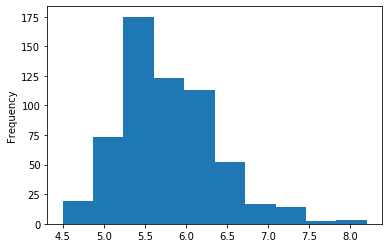

In [84]:
grocery['rating'].plot(kind='hist')

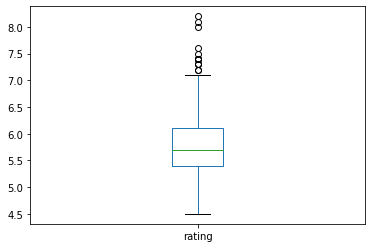

In [85]:
grocery['rating'].plot(kind='box')

Key findings:
1. 25% quantile is at 5.5
2. 75% quantile is at 6.2
3. several outliers above 7.2
4. lowest rating is 4.5
5. highest rating is 8.3

So let's cut the ratings into three categories by cutoff of 5.5 and 6. The resulting categories will be named 'low', 'median' and 'high'.

In [87]:
# create rating labels

bins = [min(grocery['rating']), 5.5, 6, max(grocery['rating'])]
labels = ['low', 'median', 'high']
grocery['rating label'] = pd.cut(grocery['rating'], bins,
                                 labels=labels, include_lowest=True)

In [88]:
grocery['rating label'].value_counts()

median    232
low       199
high      160
Name: rating label, dtype: int64

### 3.2 Split Training and Test Data<a id="10"></a>
To make sure we have not gained any information from test set, we will split the data into training and test datasets and only explore the training dataset to form the model.

In [89]:
# split data, and focus the subsequent data exploration on training data

grocery, grocery_test = train_test_split(grocery, test_size=0.25,
                                         random_state=60)

grocery.reset_index(drop=True, inplace=True)
grocery_test.reset_index(drop=True, inplace=True)

In [90]:
grocery.shape

(443, 22)

In [91]:
grocery_test.shape

(148, 22)

443 rows of data is randomly selected to be the traning set, 148 rows of data is selected as test set and will be kept untouched until finished exploratory data analysis.

### 3.3 Rating vs Brand<a id="11"></a>
Let's explore the relationship between ratings and brand

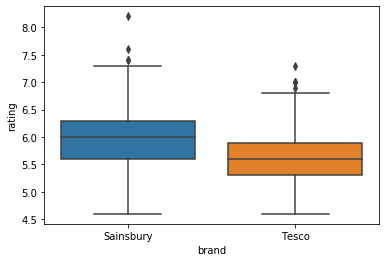

In [92]:
sns.boxplot(grocery['brand'], grocery['rating'])

Key findings:
1. Tesco(5.6) on average has lower rating than Sainsbury(6.0)
2. Tesco and Sainsbury have similar lower bound in rating, at 4.5
3. Tesco(6.8) rating upper bound is lower than Sainsbury(7.4)
4. Tesco(7.5) max rating is smaller than Sainsbury(8.5) max rating

Brand is a useful feature and it differentiates data

### 3.4 Rating vs Name<a id="12"></a>
Let's explore the relationship between ratings and name. Tesco has four kinds of stores: Tesco is supermarket, Tesco Express is high street grocery stores, Tesco Extra is larger hypermarkets, and Tesco Metro is grocery store in underground station. Sainsbury's has two kinds of stores: Sainsbury's is supermarket, and Sainsbury's Local is high street grocery stores.

In [93]:
# fucntion to plot stacked histogram
def stackhist(x, y, **kws):
    grouped = x.groupby(y)
    data = [d for _, d in grouped]
    labels = [l for l, _ in grouped]
    plt.hist(data, histtype='barstacked', label=labels,
             color=sns.color_palette('husl', len(labels)))

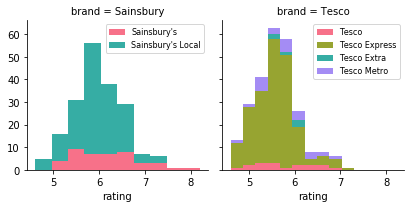

In [94]:
# stacked histogram
p = sns.FacetGrid(grocery, col='brand', col_wrap=2)
p.map(stackhist, 'rating', 'name')
p.axes[0].legend(fontsize=8)
p.axes[1].legend(fontsize=8)
p.set(ylabel="")

[Text(0, 0, "Sainsbury's Local"),
 Text(0, 0, "Sainsbury's"),
 Text(0, 0, 'Tesco Express'),
 Text(0, 0, 'Tesco Metro'),
 Text(0, 0, 'Tesco Extra'),
 Text(0, 0, 'Tesco')]

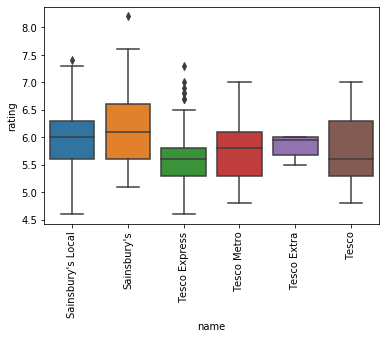

In [95]:
# box plots
ax = sns.boxplot(grocery['name'], grocery['rating'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

key findings:
1. No significant differences between sub-categories (names)
2. Sainsbury's have a higher upper bound
3. Within tesco, Tesco Express and tesco Extra make a big difference
4. Within sainsabury's, Sainsbury's is better than Sainsbury Local

We can reclassify Tesco Express, Tesco Extra, Sainsbury's, and others to be a new feature

In [96]:
# feature engineering: new name

def get_newname(df):
    list = ["Tesco Express", "Tesco Extra", "Sainsbury's"]
    df['new name'] = df['name'].copy()
    for i in range(df.shape[0]):
        if df['name'][i] not in list:
            df['new name'][i] = 'Other'
    return df


grocery = get_newname(grocery)

/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [97]:
grocery.head()

,id,brand,name,categories,latitude,longitude,location,borough,house price,rating,...,top 3 category,top 4 category,top 5 category,top 1 occurrence,top 2 occurrence,top 3 occurrence,top 4 occurrence,top 5 occurrence,rating label,new name
0,50410c21e4b06a01b9ea0d63,Sainsbury,Sainsbury's Local,Grocery Store,51.473541,-0.248917,Barnes,Richmond upon Thames,1067500.0,6.1,...,Grocery Store,Athletics & Sports,Café,3,2,2,1,1,high,Other
1,4b3f350ef964a520a6a425e3,Sainsbury,Sainsbury's,Supermarket,51.456090,0.010063,Hither Green,Lewisham,430000.0,6.1,...,Fast Food Restaurant,Supermarket,Kebab Restaurant,2,2,1,1,1,high,Sainsbury's
2,510776c4e4b07ace4ee3f65a,Tesco,Tesco Express,Grocery Store,51.582784,-0.228468,Brent Cross,Barnet,533500.0,5.5,...,Gastropub,BBQ Joint,Sushi Restaurant,3,2,1,1,1,low,Tesco Express
3,537bc0ac498e79a3c4ccce22,Tesco,Tesco Metro,Grocery Store,51.532641,-0.029336,Bow,Tower Hamlets,495000.0,5.3,...,Pub,Pizza Place,Grocery Store,4,3,3,3,2,low,Other
4,4fed7d88e4b0b6774ecc2535,Tesco,Tesco Express,Grocery Store,51.476666,-0.112519,Oval,Lambeth,588582.0,4.8,...,Deli / Bodega,Coffee Shop,Hotel,3,2,2,1,1,low,Tesco Express


We created new column called 'new name' and reclassified names into Tesco Express, Tesco Extra, Sainsbury's, and Others.

### 3.5 Rating vs Categories<a id="13"></a>
Let's explore the relationship between ratings and category.

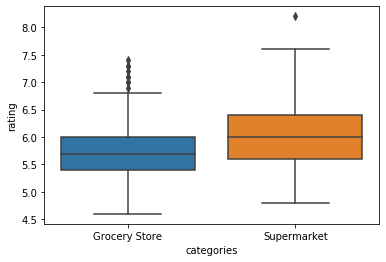

In [98]:
# box plot
sns.boxplot(grocery['categories'], grocery['rating'])

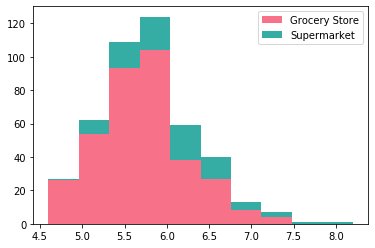

In [99]:
# histogram
stackhist(grocery['rating'], grocery['categories'])
plt.legend()

Key findings:
1. supermarket generally has higher rating than grocrey store

It's a useful feature, but the previous names alraedy contains the information of calssification of supermarket, so we will not use it as an input for the model.

### 3.6 Rating vs Borough<a id="14"></a>
Let's explore the relationship between ratings and borough.

[Text(0, 0, 'Richmond upon Thames'),
 Text(0, 0, 'Lewisham'),
 Text(0, 0, 'Barnet'),
 Text(0, 0, 'Tower Hamlets'),
 Text(0, 0, 'Lambeth'),
 Text(0, 0, 'Islington'),
 Text(0, 0, 'Kensington and Chelsea'),
 Text(0, 0, 'Westminster'),
 Text(0, 0, 'Wandsworth'),
 Text(0, 0, 'Redbridge, Waltham Forest'),
 Text(0, 0, 'Brent'),
 Text(0, 0, 'Hammersmith and Fulham'),
 Text(0, 0, 'Lambeth, Wandsworth'),
 Text(0, 0, 'Ealing'),
 Text(0, 0, 'Hackney'),
 Text(0, 0, 'Barnet, Brent, Camden'),
 Text(0, 0, 'City'),
 Text(0, 0, 'Bromley'),
 Text(0, 0, 'Waltham Forest'),
 Text(0, 0, 'Redbridge'),
 Text(0, 0, 'Haringey'),
 Text(0, 0, 'Haringey, Islington'),
 Text(0, 0, 'Merton'),
 Text(0, 0, 'Newham'),
 Text(0, 0, 'Southwark'),
 Text(0, 0, 'Camden'),
 Text(0, 0, 'Greenwich, Lewisham'),
 Text(0, 0, 'Dartford'),
 Text(0, 0, 'Greenwich'),
 Text(0, 0, 'Kensington and Chelsea\nHammersmith and Fulham'),
 Text(0, 0, 'Lambeth, Southwark'),
 Text(0, 0, 'Croydon'),
 Text(0, 0, 'Enfield'),
 Text(0, 0, 'Ealing, Hamme

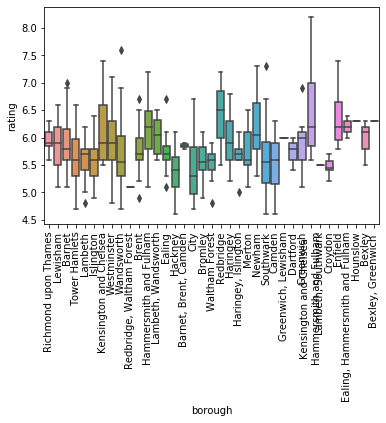

In [100]:
# box plot
ax = sns.boxplot(grocery['borough'], grocery['rating'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Key findings:
1. below 10 boroughs have high ratings:
    'Richmond upon Thames'
    'Kensington and Chelsea'
    'Hammersmith and Fulham'
    'Lambeth, Wandsworth'
    'Barnet, Brent, Camden'
    'Redbridge'
    'Newham'
    'Kensington and Chelsea\nHammersmith and Fulham'
    'Enfield'
    'Ealing, Hammersmith and Fulham'

These 10 borough should be grouped and used as a feature

In [101]:
# feature engineering: new borough

def get_newborough(df):
    list = ['Richmond upon Thames',
            'Kensington and Chelsea',
            'Hammersmith and Fulham',
            'Lambeth, Wandsworth',
            'Barnet, Brent, Camden',
            'Redbridge',
            'Newham',
            'Kensington and Chelsea\nHammersmith and Fulham',
            'Enfield',
            'Ealing, Hammersmith and Fulham']
    df['new borough'] = None
    for i in range(df.shape[0]):
        if df['borough'][i] in list:
            df['new borough'][i] = 'high'
        else:
            df['new borough'][i] = 'other'
    return df


grocery = get_newborough(grocery)

/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [102]:
grocery.head()

,id,brand,name,categories,latitude,longitude,location,borough,house price,rating,...,top 4 category,top 5 category,top 1 occurrence,top 2 occurrence,top 3 occurrence,top 4 occurrence,top 5 occurrence,rating label,new name,new borough
0,50410c21e4b06a01b9ea0d63,Sainsbury,Sainsbury's Local,Grocery Store,51.473541,-0.248917,Barnes,Richmond upon Thames,1067500.0,6.1,...,Athletics & Sports,Café,3,2,2,1,1,high,Other,high
1,4b3f350ef964a520a6a425e3,Sainsbury,Sainsbury's,Supermarket,51.456090,0.010063,Hither Green,Lewisham,430000.0,6.1,...,Supermarket,Kebab Restaurant,2,2,1,1,1,high,Sainsbury's,other
2,510776c4e4b07ace4ee3f65a,Tesco,Tesco Express,Grocery Store,51.582784,-0.228468,Brent Cross,Barnet,533500.0,5.5,...,BBQ Joint,Sushi Restaurant,3,2,1,1,1,low,Tesco Express,other
3,537bc0ac498e79a3c4ccce22,Tesco,Tesco Metro,Grocery Store,51.532641,-0.029336,Bow,Tower Hamlets,495000.0,5.3,...,Pizza Place,Grocery Store,4,3,3,3,2,low,Other,other
4,4fed7d88e4b0b6774ecc2535,Tesco,Tesco Express,Grocery Store,51.476666,-0.112519,Oval,Lambeth,588582.0,4.8,...,Coffee Shop,Hotel,3,2,2,1,1,low,Tesco Express,other


We have created a new column called 'new borough' to store boroughs with high ratings and the others.

### 3.7 Rating vs House Price<a id="15"></a>
Let's explore the relationship between ratings and house prices.

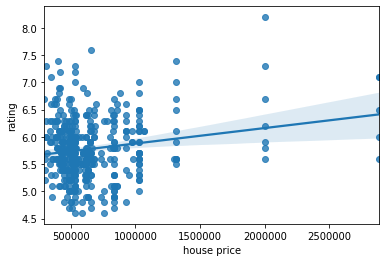

In [109]:
sns.regplot('house price', 'rating', grocery)

In [104]:
grocery[['house price', 'rating']].corr()

,house price,rating
house price,1.000000,0.187729
rating,0.187729,1.000000


Key findings:
1. there is weak positive relationship between house price and rating. 
2. A significant difference in low bounds between stores where houseprice above 1100000 and those below 11000000

We should convert house prices into two categories with one below 1100000 and one above 1100000

In [105]:
# feature engineering: house price label

def get_pricelabel(df):
    bins = [0, 1100000, 5000000]
    labels = ['normal', 'luxury']
    df['house price label'] = pd.cut(df['house price'], bins,
                                     labels=labels, include_lowest=True)
    return df


grocery = get_pricelabel(grocery)

In [106]:
grocery['house price label'].value_counts()

normal    420
luxury     23
Name: house price label, dtype: int64

Now we created labels for house prices and stored in column 'house price label'. Label 'luxury' is where house prices above 1100000.

### 3.8 Rating vs Total<a id="16"></a>
Let's explore the relationship between ratings and total venues in the neighborhood.

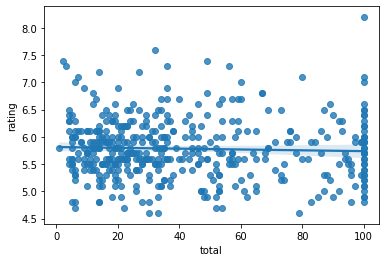

In [107]:
sns.regplot('total', 'rating', grocery)

In [108]:
grocery[['total', 'rating']].corr()

,total,rating
total,1.000000,-0.041357
rating,-0.041357,1.000000


Key findings:
1. very weak relationship

total should not be used as a input feature

### 3.9 Rating vs Venues Occurrence <a id="17"></a>
Let's explore the relationship between ratings and most popular venues occurrence in the neighborhood.

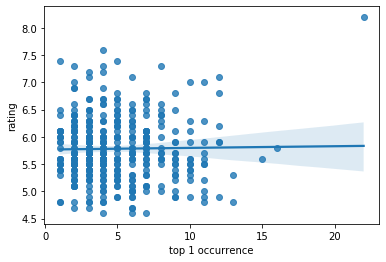

In [110]:
sns.regplot('top 1 occurrence', 'rating', grocery)

In [111]:
grocery[['top 1 occurrence', 'rating']].corr()

,top 1 occurrence,rating
top 1 occurrence,1.000000,0.016071
rating,0.016071,1.000000


In [112]:
grocery[['top 2 occurrence', 'rating']].corr()

,top 2 occurrence,rating
top 2 occurrence,1.000000,-0.091546
rating,-0.091546,1.000000


In [113]:
grocery[['top 3 occurrence', 'rating']].corr()

,top 3 occurrence,rating
top 3 occurrence,1.000000,-0.048902
rating,-0.048902,1.000000


In [114]:
grocery[['top 4 occurrence', 'rating']].corr()

,top 4 occurrence,rating
top 4 occurrence,1.000000,-0.074201
rating,-0.074201,1.000000


In [115]:
grocery[['top 5 occurrence', 'rating']].corr()

,top 5 occurrence,rating
top 5 occurrence,1.000000,-0.061685
rating,-0.061685,1.000000


Key findings:
1. no significant relationships

We should ignore venue occurrences

### 3.10 Rating vs Top Concentration <a id="18"></a>
Let's explore the relationship between ratings and top concentration in the neighborhood. Top 1 concentration is defined as: top 1 occurrence/total. Top 5 concentration is defined as: sum of top 1-5 occurrence/total.

In [116]:
# top 1 concentration
grocery['top 1 concentration'] = grocery['top 1 occurrence'] / grocery['total']

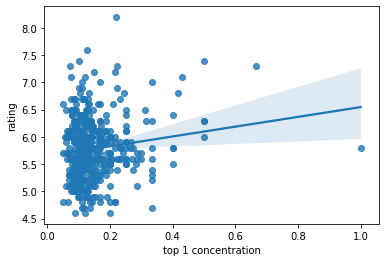

In [117]:
sns.regplot('top 1 concentration', 'rating', grocery)

In [118]:
grocery[['top 1 concentration', 'rating']].corr()

,top 1 concentration,rating
top 1 concentration,1.000000,0.143042
rating,0.143042,1.000000


In [119]:
# top 5 concentration
top = ['top {} occurrence'.format(i+1) for i in range(5)]
grocery['top 5 concentration'] = grocery[top].sum(axis=1) / grocery['total']

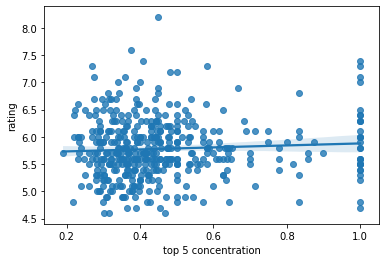

In [120]:
sns.regplot('top 5 concentration', 'rating', grocery)

In [121]:
grocery[['top 5 concentration', 'rating']].corr()

,top 5 concentration,rating
top 5 concentration,1.00000,0.06356
rating,0.06356,1.00000


Key findings:
1. top 1 concentration exhibites some explaining power
2. top 5 concentration exhibites no explaining power

top 1 concentration is useful feature

### 3.11 Rating vs Business Diversification <a id="19"></a>
Instead of top 1 concentration, another way to defind business diversity is business diversification, which is defined as: Sum( (occurrence/total)^2 ).

In [122]:
# explore: rating vs business diversification

grocery['business divers'] = grocery[top].div(grocery['total'], axis=0)\
    .pow(2).sum(axis=1)

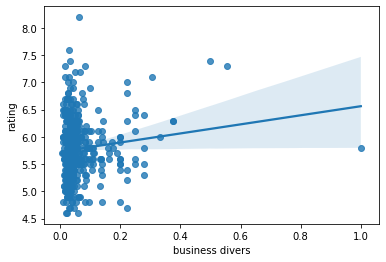

In [123]:
sns.regplot('business divers', 'rating', grocery)

In [124]:
grocery[['business divers', 'rating']].corr()

,business divers,rating
business divers,1.000000,0.121188
rating,0.121188,1.000000


Key findings:
1. business diversification shows some explaining power
2. more concentrated business neighborhood tend to show higher rating

business diversification is a useful feature. Because Business diversification uses more information, we will keep business diversification instead of top 1 concentration as input feature.

### 3.12 Rating vs Top 1 Category <a id="20"></a>
Let's explore the relationship between rating and top 1 category.

[Text(0, 0, 'Pub'),
 Text(0, 0, 'Coffee Shop'),
 Text(0, 0, 'Café'),
 Text(0, 0, 'Supermarket'),
 Text(0, 0, 'Chinese Restaurant'),
 Text(0, 0, 'Scandinavian Restaurant'),
 Text(0, 0, 'Portuguese Restaurant'),
 Text(0, 0, 'Italian Restaurant'),
 Text(0, 0, 'Platform'),
 Text(0, 0, 'Park'),
 Text(0, 0, 'Metro Station'),
 Text(0, 0, 'Gym / Fitness Center'),
 Text(0, 0, 'Grocery Store'),
 Text(0, 0, 'Hotel'),
 Text(0, 0, 'Clothing Store'),
 Text(0, 0, 'Trail'),
 Text(0, 0, 'Pizza Place'),
 Text(0, 0, 'Indoor Play Area'),
 Text(0, 0, 'Bar'),
 Text(0, 0, 'Bus Stop'),
 Text(0, 0, 'Restaurant'),
 Text(0, 0, 'Turkish Restaurant'),
 Text(0, 0, 'French Restaurant'),
 Text(0, 0, 'Food Truck'),
 Text(0, 0, 'Fast Food Restaurant'),
 Text(0, 0, 'Indian Restaurant'),
 Text(0, 0, 'Bakery'),
 Text(0, 0, 'Brewery'),
 Text(0, 0, 'Train Station'),
 Text(0, 0, 'Gym'),
 Text(0, 0, 'Food & Drink Shop'),
 Text(0, 0, 'Bus Station'),
 Text(0, 0, 'Lebanese Restaurant'),
 Text(0, 0, 'Mini Golf'),
 Text(0, 0, 'Coc

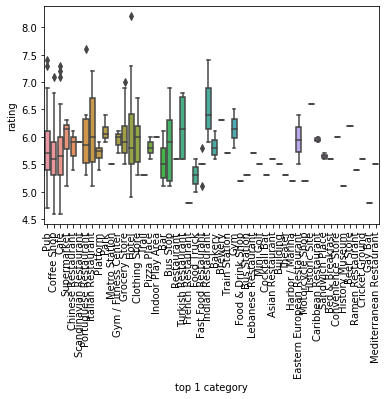

In [125]:
ax = sns.boxplot(grocery['top 1 category'], grocery['rating'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [127]:
grocery['top 1 category'].value_counts()

Pub                            113
Coffee Shop                     85
Café                            52
Grocery Store                   41
Hotel                           32
Italian Restaurant              15
Clothing Store                  11
Supermarket                      8
Portuguese Restaurant            6
Platform                         6
Bus Stop                         5
Fast Food Restaurant             5
Turkish Restaurant               4
Bar                              4
Park                             4
Bakery                           4
Chinese Restaurant               3
Gym / Fitness Center             3
Indian Restaurant                3
Caribbean Restaurant             2
Gym                              2
Pizza Place                      2
Food Truck                       2
Eastern European Restaurant      2
Sandwich Place                   2
Beer Store                       1
Restaurant                       1
Trail                            1
Metro Station       

key findings:

some categories have small counts, let's only examine those with count larger than 5

we can have three categories of venues grouped by their ratings:

high:
'Grocery Store'
'Hotel'
'Italian Restaurant'
'Clothing Store'
'Supermarket'
'Portuguese Restaurant'

low:
'Coffee Shop'
'Café'

median:
'Pub'
'Platform'

In [128]:
# explore: rating vs top 1 venues - count %

high = ['Grocery Store',
        'Hotel',
        'Clothing Store',
        'Italian Restaurant',
        'Supermarket',
        'Portuguese Restaurant']

low = ['Coffee Shop',
       'Café']

median = ['Pub',
          'Platform']

In [130]:
txt = high[1]

print(sum(grocery['rating'][grocery['top 1 category'] == txt] > 6) / x[txt])

0.4375


In [132]:
txt = low[0]

print(sum(grocery['rating'][grocery['top 1 category'] == txt] < 5.5) / x[txt])

0.3411764705882353


Key findings:
1. percentages confirms the findings above

We can reclassify the venues into the above 3 + others

In [133]:
# feature engineering: reclassify top 1 category

def get_reclass(df):
    high = ['Grocery Store',
            'Hotel',
            'Clothing Store',
            'Italian Restaurant',
            'Supermarket',
            'Portuguese Restaurant']

    low = ['Coffee Shop',
           'Café']

    median = ['Pub',
              'Platform']

    df['top 1 reclass'] = None
    x = df['top 1 category']
    for i in range(df.shape[0]):
        if x[i] in high:
            df['top 1 reclass'][i] = 'high'
        elif x[i] in median:
            df['top 1 reclass'][i] = 'median'
        elif x[i] in low:
            df['top 1 reclass'][i] = 'low'
        else:
            df['top 1 reclass'][i] = 'other'
    return df


grocery = get_reclass(grocery)

/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipyke

[Text(0, 0, 'median'),
 Text(0, 0, 'low'),
 Text(0, 0, 'high'),
 Text(0, 0, 'other')]

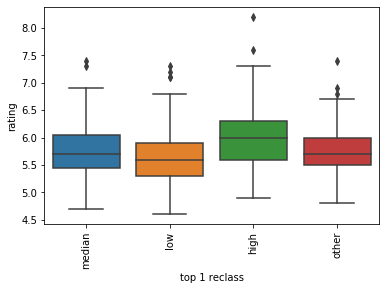

In [134]:
ax = sns.boxplot(grocery['top 1 reclass'], grocery['rating'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Key findings:
1. low, median, high shows desired order in median rating
2. other looks like median

This reclassification should be used as an input feature

### 3.13 Re-examine Rating Labels with Selected Features <a id="21"></a>
So far, we have examined the relationships with ratings and found the below useful features:
1. new name (categorical)
2. new borough (categorical)
3. house price label (categorical)
4. business diversification (numerical)
5. top 1 reclass (categorical)

Since our target is rating label, let's re-examine these features with rating labels to confirm the relationships.

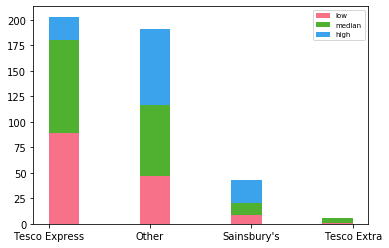

In [135]:
# re-examine useful features with rating label: new name

stackhist(grocery['new name'], grocery['rating label'])
plt.legend(fontsize=7)

Key findings:
1. each name does show tendancy to rating labels
2. most Tesco Express are below high
3. most Sainsbury's are high
4. most Tesco Extra are median
5. other are evenly distributed, no obvious pattern

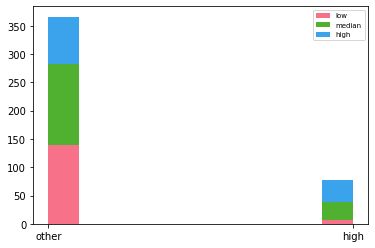

In [136]:
# re-examine useful features with rating label: new borough

stackhist(grocery['new borough'], grocery['rating label'])
plt.legend(fontsize=7)

Key findings:
1. other show no pattern
2. high are most in median and high range

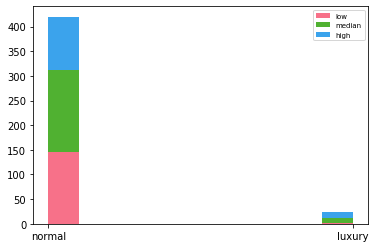

In [137]:
# re-examine useful features with rating label: house price label

stackhist(grocery['house price label'], grocery['rating label'])
plt.legend(fontsize=7)

Key findings:
1. luxury are most in high and median
2. normal show no pattern

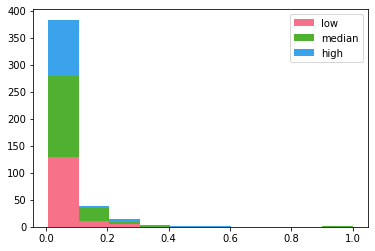

In [138]:
# re-examine useful features with rating label: business diversification

stackhist(grocery['business divers'], grocery['rating label'])
plt.legend()

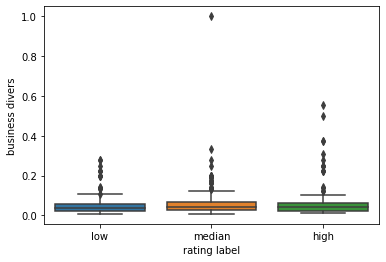

In [139]:
sns.boxplot(grocery['rating label'], grocery['business divers'])

Key findings:
1. the more concentrated the business, the higher rating

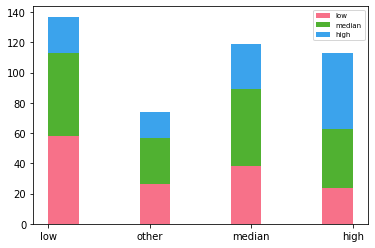

In [140]:
# %% re-examine useful features with rating label: top 1 reclassification

stackhist(grocery['top 1 reclass'], grocery['rating label'])
plt.legend(fontsize=7)

So, these features show desired relationships with rating labels. Let's use these features as inputs to create models.

## 4. Machine Learning Models <a id="22"></a>
This section we will utilize the features we obtained from previous sections and build a fine-tuned classification model to predict the rating labels and explain the drivers of those ratings.

### 4.1 Split Data <a id="23"></a>
We will one-hot encode the features and then form input data X and label y.

In [141]:
# one-hot encoding features

grocery = pd.concat([grocery,
                     pd.get_dummies(grocery['new name'], prefix='name')
                     ], axis=1)

grocery = pd.concat([grocery,
                     pd.get_dummies(grocery['new borough'], prefix='borough')
                     ], axis=1)

grocery = pd.concat([grocery,
                     pd.get_dummies(grocery['house price label'], prefix='price')
                     ], axis=1)

grocery = pd.concat([grocery,
                     pd.get_dummies(grocery['top 1 reclass'], prefix='top1')
                     ], axis=1)

In [142]:
grocery.shape

(443, 41)

In [143]:
grocery.head()

,id,brand,name,categories,latitude,longitude,location,borough,house price,rating,...,name_Tesco Express,name_Tesco Extra,borough_high,borough_other,price_normal,price_luxury,top1_high,top1_low,top1_median,top1_other
0,50410c21e4b06a01b9ea0d63,Sainsbury,Sainsbury's Local,Grocery Store,51.473541,-0.248917,Barnes,Richmond upon Thames,1067500.0,6.1,...,0,0,1,0,1,0,0,0,1,0
1,4b3f350ef964a520a6a425e3,Sainsbury,Sainsbury's,Supermarket,51.456090,0.010063,Hither Green,Lewisham,430000.0,6.1,...,0,0,0,1,1,0,0,0,1,0
2,510776c4e4b07ace4ee3f65a,Tesco,Tesco Express,Grocery Store,51.582784,-0.228468,Brent Cross,Barnet,533500.0,5.5,...,1,0,0,1,1,0,0,1,0,0
3,537bc0ac498e79a3c4ccce22,Tesco,Tesco Metro,Grocery Store,51.532641,-0.029336,Bow,Tower Hamlets,495000.0,5.3,...,0,0,0,1,1,0,0,1,0,0
4,4fed7d88e4b0b6774ecc2535,Tesco,Tesco Express,Grocery Store,51.476666,-0.112519,Oval,Lambeth,588582.0,4.8,...,1,0,0,1,1,0,0,1,0,0


In [146]:
# target and input data

# n dummies only leave n-1 features
features = ['business divers',
            "name_Sainsbury's", 'name_Tesco Express', 'name_Tesco Extra',
            'borough_high',
            'price_luxury',
            'top1_high', 'top1_low', 'top1_median']

X = grocery[features].copy()
y = grocery['rating label'].copy()

In [147]:
X.head()

,business divers,name_Sainsbury's,name_Tesco Express,name_Tesco Extra,borough_high,price_luxury,top1_high,top1_low,top1_median
0,0.043084,0,0,0,1,0,0,0,1
1,0.056122,1,0,0,0,0,0,0,1
2,0.071111,0,1,0,0,0,0,1,0
3,0.081597,0,0,0,0,0,0,1,0
4,0.096939,0,1,0,0,0,0,1,0


In [148]:
y.head()

0    high
1    high
2     low
3     low
4     low
Name: rating label, dtype: object

### 4.2 Baseline Models and Untuned Models <a id="24"></a>
We will build two baseline models and several untuned machine learning models to test the explaining power of our features and ML models. Models will be tested by 5-fold cross validation.

In [149]:
# baseline models

# random guessing with equal probability
base1 = DummyClassifier(strategy='uniform')

# random guessing with corresponding label frequencies
base2 = DummyClassifier(strategy='stratified')


In [150]:
# %% machine learning models without tuning parameters

dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [151]:
# %% raw models results

models = [dt, knn, svc, rf, xgb, base1, base2]

results = pd.DataFrame(columns=['mean accuracy', 'std accuracy'],
                       index=['Decision Tree', 'KNN', 'SVC', 'Random Forest',
                              'XGBoost', 'Base Model 1', 'Base Model 2'])

for i in range(len(models)):
    scores = cross_val_score(models[i], X, y, cv=5)
    results.iloc[i, 0] = np.mean(scores)
    results.iloc[i, 1] = np.std(scores)

results.sort_values('mean accuracy', ascending=False, inplace=True)

In [152]:
results

,mean accuracy,std accuracy
KNN,0.478652,0.0296194
Decision Tree,0.465169,0.0485704
SVC,0.460444,0.0378738
XGBoost,0.45383,0.0371145
Random Forest,0.451532,0.0481365
Base Model 2,0.336313,0.0389415
Base Model 1,0.329699,0.052785


Key findings:
1. all ML models outperformed the baseline random guessing models. It means that our input features and machine learning models do provide extra information to explain the store ratings.
2. KNN provides best accuracy with smallest standard deviation of predictions.

### 4.3 Fine Tuned Models <a id="25"></a>
Let's fine-tune the models with grid search to improve the prediction Capability.

In [153]:
# grid search CV

grid_dt = {'max_depth': [None, 3, 4, 5, 6],
           'min_samples_split': [2, 3, 4, 5],
           'min_samples_leaf': [1, 2, 3]}

grid_knn = {'n_neighbors': np.arange(3, 21)}

grid_svc = {'C': [2e-2, 2e-1, 2, 2e2],
            'gamma': [2e-2, 2e-1, 0, 2, 2e2]}

grid_rf = {'n_estimators': [5, 10, 20, 50, 100],
           'max_depth': [None, 3, 4, 5, 6, 7],
           'min_samples_split': [2, 3, 4, 5],
           'min_samples_leaf': [1, 2, 3]}

grid_xgb = {'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3],
            'max_depth': [3, 4, 5, 6, 7],
            'subsample': [0.4, 0.6, 0.8, 1],
            'colsample_bytree': [0.5, 0.7, 0.9],
            'gamma': [0, 0.1, 0.2, 0.3, 0.5]}

gscv_dt = GridSearchCV(DecisionTreeClassifier(), grid_dt, cv=5)
gscv_dt.fit(X, y)

gscv_knn = GridSearchCV(KNeighborsClassifier(), grid_knn, cv=5)
gscv_knn.fit(X, y)

gscv_svc = GridSearchCV(SVC(), grid_svc, cv=5)
gscv_svc.fit(X, y)

gscv_rf = GridSearchCV(RandomForestClassifier(), grid_rf, cv=5)
gscv_rf.fit(X, y)

gscv_xgb = GridSearchCV(XGBClassifier(), grid_xgb, cv=5)
gscv_xgb.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.5, 0.7, 0.9],
                         '

In [154]:
# grid search results

search = [gscv_dt, gscv_knn, gscv_svc, gscv_rf, gscv_xgb]
model_names = ['Decision Tree Tuned', 'KNN Tuned', 'SVC Tuned',
               'Random Forest Tuned', 'XGBoost Tuned']

for i in range(len(search)):
    score = search[i].cv_results_['mean_test_score'][search[i].best_index_]
    std = search[i].cv_results_['std_test_score'][search[i].best_index_]
    s = pd.Series(data={'mean accuracy': score, 'std accuracy': std},
                  name=model_names[i])
    results = results.append(s)

results.sort_values('mean accuracy', ascending=False, inplace=True)


In [155]:
results

,mean accuracy,std accuracy
XGBoost Tuned,0.514888,0.067094
Random Forest Tuned,0.50572,0.0284465
KNN Tuned,0.487666,0.0459845
KNN,0.478652,0.0296194
Decision Tree Tuned,0.471859,0.0299297
Decision Tree,0.465169,0.0485704
SVC,0.460444,0.0378738
SVC Tuned,0.458248,0.0208889
XGBoost,0.45383,0.0371145
Random Forest,0.451532,0.0481365


Key findings:
1. almost all models improves their performances, except for SVC.
2. xgb model has the best cross validation score but also the highest standard deviation.
3. random forest shows slightly worse score than xgb, and it has much smaller standard deviation.
4. random forest is the best model

In [157]:
# best models

dt_tuned = gscv_dt.best_estimator_

knn_tuned = gscv_knn.best_estimator_

svc_tuned = gscv_svc.best_estimator_

rf_tuned = gscv_rf.best_estimator_

xgb_tuned = gscv_xgb.best_estimator_


### 4.4 Feature Importances  and Feature Selection<a id="26"></a>
Let's examine the feature importances from the two best models (XGB and Random Forest) and select best features.

<BarContainer object of 9 artists>

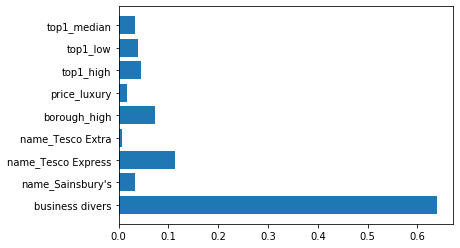

In [158]:
plt.barh(X.columns, rf_tuned.feature_importances_)

<BarContainer object of 9 artists>

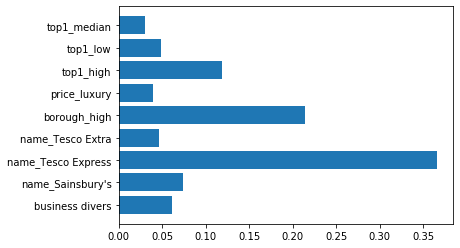

In [159]:
plt.barh(X.columns, xgb_tuned.feature_importances_)

Key findings:
1. the primary feature of random forest model is business diversification
2. the primary feature of xgb model is name_Tesco Express
3. borough_high and top_high are both important features for both models
4. name_Tesco Extra, price_luxury and top1_median do not contribute much to the model

### 4.5 Retraining Models with Less Features<a id="27"></a>
Let's drop the less important features from previous section and retrain models, and observe the change of the results.

In [189]:
# feature selection: drop less important features and retrain

X2 = X.drop(['name_Tesco Extra', 'price_luxury', 'top1_median'], axis=1)

gscv_dt2 = GridSearchCV(DecisionTreeClassifier(), grid_dt, cv=5)
gscv_dt2.fit(X2, y)

gscv_knn2 = GridSearchCV(KNeighborsClassifier(), grid_knn, cv=5)
gscv_knn2.fit(X2, y)

gscv_svc2 = GridSearchCV(SVC(), grid_svc, cv=5)
gscv_svc2.fit(X2, y)

gscv_rf2 = GridSearchCV(RandomForestClassifier(), grid_rf, cv=5)
gscv_rf2.fit(X2, y)

gscv_xgb2 = GridSearchCV(XGBClassifier(), grid_xgb, cv=5)
gscv_xgb2.fit(X2, y)

search2 = [gscv_dt2, gscv_knn2, gscv_svc2, gscv_rf2, gscv_xgb2]
model_names = ['Decision Tree Tuned 2', 'KNN Tuned 2', 'SVC Tuned 2',
               'Random Forest Tuned 2', 'XGBoost Tuned 2']

for i in range(len(search2)):
    score = search2[i].cv_results_['mean_test_score'][search2[i].best_index_]
    std = search2[i].cv_results_['std_test_score'][search2[i].best_index_]
    s = pd.Series(data={'mean accuracy': score, 'std accuracy': std},
                  name=model_names[i])
    results = results.append(s)

results.sort_values('mean accuracy', ascending=False, inplace=True)

In [191]:
results

,mean accuracy,std accuracy
XGBoost Tuned,0.514888,0.067094
Random Forest Tuned,0.50572,0.0284465
Random Forest Tuned 2,0.503447,0.0154755
XGBoost Tuned 2,0.501251,0.0548969
KNN Tuned 2,0.49216,0.0345727
KNN Tuned,0.487666,0.0459845
KNN,0.478652,0.0296194
Decision Tree Tuned 2,0.471859,0.0299297
Decision Tree Tuned,0.471859,0.0299297
SVC Tuned 2,0.469484,0.0315936


Key findings:
1. the top 2 retrained models did not beat the original models in terms of accuracy
2. the retrained models reduced prediction variance
3. because the accuracy is not improved, we will stick to the original tuned models

### 4.5 Models Ensembling<a id="28"></a>
Considering all fine-tuned models generates quite good results, we will put all five models together and form a ensemble model. We will use simple hard voting for the model ensembling.

In [202]:
# add voting classifier

voting = VotingClassifier(
    estimators=[('dt', dt_tuned), ('knn', knn_tuned), ('svc', svc_tuned),
                ('rf', rf_tuned), ('xgb', xgb_tuned)],
    voting='hard')

scores = cross_val_score(voting, X, y, cv=5)
s = pd.Series(data={'mean accuracy': np.mean(scores),
                    'std accuracy': np.std(scores)},
              name='Voting')

results = results.append(s)

results.sort_values('mean accuracy', ascending=False, inplace=True)

In [203]:
results

,mean accuracy,std accuracy
Voting,0.530516,0.0170639
XGBoost Tuned,0.514888,0.067094
Random Forest Tuned,0.50572,0.0284465
Random Forest Tuned 2,0.503447,0.0154755
XGBoost Tuned 2,0.501251,0.0548969
KNN Tuned 2,0.49216,0.0345727
KNN Tuned,0.487666,0.0459845
KNN,0.478652,0.0296194
Decision Tree Tuned,0.471859,0.0299297
Decision Tree Tuned 2,0.471859,0.0299297


Key findings:
1. Voting classifier beat all other models with smaller prediction variance
2. Voting classifier is the final prediction model

## 5. Predictions<a id="29"></a>
In this section, machine learning models from previous section will be evaluated by test dataset.

### 5.1 Transform Test Data<a id="30"></a>
Firstly let's transform the test data by the same methonds applied on training data and get features.

In [168]:
# transform test data

grocery_test = pd.read_csv('grocery_test_raw.csv', index_col=0)

# get features
grocery_test['business divers'] = grocery_test[top].\
    div(grocery_test['total'], axis=0).pow(2).sum(axis=1)

grocery_test = get_newname(grocery_test)

grocery_test = get_newborough(grocery_test)

grocery_test = get_pricelabel(grocery_test)

grocery_test = get_reclass(grocery_test)

# one-hot encoding features
grocery_test = pd.concat([grocery_test,
                     pd.get_dummies(grocery_test['new name'], prefix='name')
                     ], axis=1)

grocery_test = pd.concat([grocery_test,
                     pd.get_dummies(grocery_test['new borough'], prefix='borough')
                     ], axis=1)

grocery_test = pd.concat([grocery_test,
                     pd.get_dummies(grocery_test['house price label'], prefix='price')
                     ], axis=1)

grocery_test = pd.concat([grocery_test,
                     pd.get_dummies(grocery_test['top 1 reclass'], prefix='top1')
                     ], axis=1)

/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/victor/opt/anaconda3/lib/python3.7/site-packages/ipy

In [169]:
# get input data and label for model

grocery_test['name_Tesco Extra'] = 0  # this label does not exist, let's add it
X_test = grocery_test[features].copy()
y_test = grocery_test['rating label'].copy()

In [170]:
X_test.head()

,business divers,name_Sainsbury's,name_Tesco Express,name_Tesco Extra,borough_high,price_luxury,top1_high,top1_low,top1_median
0,0.138889,0,1,0,0,0,1,0,0
1,0.029240,0,1,0,0,0,0,1,0
2,0.027548,0,1,0,0,0,0,1,0
3,0.009072,0,1,0,0,0,0,1,0
4,0.027778,1,0,0,0,0,0,0,1


In [165]:
y_test

0         low
1         low
2         low
3         low
4        high
        ...  
143    median
144      high
145       low
146       low
147      high
Name: rating label, Length: 148, dtype: object

### 5.2 Prediction Results<a id="31"></a>
Let's predict the rating labels by fined tuned models.

In [211]:
# predict test data

tuned_models = [dt_tuned, knn_tuned, svc_tuned, rf_tuned, xgb_tuned,
                base1, base2, voting]

prediction_results = pd.DataFrame(columns=['accuracy'],
                                  index=['Decision Tree', 'KNN', 'SVC',
                                         'Random Forest', 'XGBoost',
                                         'Base Model 1', 'Base Model 2', 'Voting'])

base1.fit(X, y)
base2.fit(X, y)
voting.fit(X, y)

for i in range(len(tuned_models)):
    yhat = tuned_models[i].predict(X_test)
    scores = accuracy_score(y_test, yhat)
    prediction_results.iloc[i, 0] = scores

prediction_results.sort_values('accuracy', ascending=False, inplace=True)

In [212]:
prediction_results

,accuracy
Voting,0.513514
KNN,0.493243
SVC,0.486486
Decision Tree,0.472973
Random Forest,0.452703
XGBoost,0.439189
Base Model 2,0.398649
Base Model 1,0.337838


Key findings:
1. voting classifier, as our final model, still generated the best out-of-sample perforamcne
2. random Forest and XGBoost were surprisingly beated by other three methods, which indicates the overfitting of the two models in the parameter-tuning process
3. all machine learning models outperformed the baseline models

## 6. Conclusions<a id="32"></a>
To answer the question of what drives the customer ratings of a grocery store, five distinct features are utilized and an ensemble classification model consisted of five different underlying machine learning models are developed. Based on the feature importances of the models and observations from exploratory analysis, the following conclusions are presented:
1. A grocery store located in a neighbourhood with high business diversity tends to have low ratings, or, surrounding commercial activity hurts grocery store ratings.
2. Tesco Express has relatively low ratings comparing to other Tesco stores or Sainsbury's.
3. A grocery store located in Richmond upon Thames, Kensington and Chelsea, Hammersmith and Fulham, Ealing and Redbridge tends to have high ratings.
4. A grocery store that is close to it's competitors, i.e. grocery stores and supermarkets, tends to have higher ratings.
5. A neighbourhood with very high house prices tends to have positve impact on grocery store ratings.
6. A voting classifier with decision tree, SVC, random forest, KNN and XGBoost can utilize the features well and produce reasonable out-of-sample results.